# 41 · Embedding‑Based Novelty Detection Demo
_Last updated 2025-10-26_

**Goal**

Use embeddings to detect **distinctive / novel items** among a set of products.

**Recipe**
1. Build embeddings (`OpenAI text-embedding-3-large`).
2. Compute pairwise distances.
3. Score novelty via **KNN distance** and **IsolationForest**.
4. Optional: cluster with KMeans; visualize a 2‑D projection (PCA).

In production, you embed once and cache, then score new arrivals on the fly.

## API key + install

Looks for `OPENAI_API_KEY`, else reads `key/openai_key.txt` (same pattern as earlier notebooks).

```bash
# %pip -q install --upgrade openai python-dotenv langchain_openai scikit-learn pandas numpy matplotlib
```


In [19]:
import os, pathlib, numpy as np, pandas as pd
from sklearn.neighbors import NearestNeighbors
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from openai import OpenAI
from langchain_openai import OpenAIEmbeddings

# key file fallback
key_file = pathlib.Path('key/openai_key.txt')
if os.getenv('OPENAI_API_KEY') is None and key_file.exists():
    os.environ['OPENAI_API_KEY'] = key_file.read_text().strip()
if not os.getenv('OPENAI_API_KEY'):
    raise ValueError('Provide OPENAI_API_KEY or create key/openai_key.txt')

client = OpenAI()


## 1 · Create products DataFrame inline (20 real items)
We'll embed `brand — product_name: description`.

In [20]:
products = [
    {"brand": "Apple",       "product_name": "AirPods Pro",         "description": "Wireless earbuds with noise cancellation and adaptive transparency."},
    {"brand": "Samsung",     "product_name": "Galaxy S24 Ultra",    "description": "Flagship smartphone with advanced camera, AI tools, and S Pen."},
    {"brand": "Sony",        "product_name": "WH-1000XM5",          "description": "Over-ear headphones with industry-leading noise cancellation and comfort."},
    {"brand": "Dyson",       "product_name": "V15 Detect",          "description": "Cordless vacuum with laser dust detection and powerful cleaning."},
    {"brand": "Nintendo",    "product_name": "Switch OLED",         "description": "Hybrid console with vibrant OLED display for handheld or docked play."},
    {"brand": "Amazon",      "product_name": "Kindle Paperwhite",   "description": "Waterproof e-reader with warm light and weeks of battery life."},
    {"brand": "Bose",        "product_name": "QC Ultra",            "description": "Premium wireless headphones with immersive spatial audio and cancellation."},
    {"brand": "KitchenAid",  "product_name": "Artisan Mixer",       "description": "Iconic tilt-head mixer with versatile baking attachments and power."},
    {"brand": "Instant",     "product_name": "Instant Pot Duo",     "description": "Multicooker combining pressure, slow cook, rice, and yogurt modes."},
    {"brand": "LEGO",        "product_name": "Millennium Falcon",   "description": "Ultimate Collector Series starship with intricate detailing for enthusiasts."},
    {"brand": "Patagonia",   "product_name": "Better Sweater",      "description": "Warm fleece from recycled materials with a sweater-knit face."},
    {"brand": "YETI",        "product_name": "Rambler 20oz",        "description": "Durable stainless tumbler with insulation for hot and cold drinks."},
    {"brand": "Hydro Flask", "product_name": "Wide Mouth 32oz",     "description": "Insulated water bottle with leakproof flex cap and temperature retention."},
    {"brand": "lululemon",   "product_name": "Align Pant 25\"",     "description": "Buttery-soft yoga leggings prioritizing comfort, stretch, and minimal seams."},
    {"brand": "Peloton",     "product_name": "Bike+",               "description": "Connected stationary bike with rotating screen and live classes."},
    {"brand": "Meta",        "product_name": "Quest 3",             "description": "Standalone mixed-reality VR headset for gaming and productivity."},
    {"brand": "Tesla",       "product_name": "Wall Connector",      "description": "Home EV charger with Wi-Fi connectivity and adjustable power levels."},
    {"brand": "IKEA",        "product_name": "BILLY",               "description": "Affordable bookshelf system with adjustable shelves and extensions."},
    {"brand": "Ooni",        "product_name": "Karu 12",             "description": "Portable outdoor pizza oven reaching high temperatures for Neapolitan pies."},
    {"brand": "Stanley",     "product_name": "Quencher 40oz",       "description": "Insulated tumbler with handle and straw lid for long-lasting cold."}
]

import pandas as pd
df = pd.DataFrame(products)
df['text'] = df['brand'] + ' — ' + df['product_name'] + ': ' + df['description']
df.head()

,brand,product_name,description,text
0,Apple,AirPods Pro,Wireless earbuds with noise cancellation and a...,Apple — AirPods Pro: Wireless earbuds with noi...
1,Samsung,Galaxy S24 Ultra,"Flagship smartphone with advanced camera, AI t...",Samsung — Galaxy S24 Ultra: Flagship smartphon...
2,Sony,WH-1000XM5,Over-ear headphones with industry-leading nois...,Sony — WH-1000XM5: Over-ear headphones with in...
3,Dyson,V15 Detect,Cordless vacuum with laser dust detection and ...,Dyson — V15 Detect: Cordless vacuum with laser...
4,Nintendo,Switch OLED,Hybrid console with vibrant OLED display for h...,Nintendo — Switch OLED: Hybrid console with vi...


## 2 · Build embeddings
We’ll use `text-embedding-3-large` with `langchain_openai.OpenAIEmbeddings` to keep parity with your earlier notebook.

In [21]:
embedder = OpenAIEmbeddings(model='text-embedding-3-large', dimensions=3072)
emb = embedder.embed_documents(df['text'].tolist())  # shape (20, 3072)
X = np.array(emb, dtype=float)
X.shape

(20, 3072)

## 3 · Novelty scoring

**KNN distance**: for each item, compute average distance to its *k* nearest neighbors.
Higher average distance ⇒ more isolated ⇒ more "novel".

**IsolationForest**: tree‑based anomaly score on the embedding vectors.

In [22]:
k = 5
nbrs = NearestNeighbors(n_neighbors=k+1, metric='cosine').fit(X)
distances, indices = nbrs.kneighbors(X)  # includes self at index 0
avg_knn_dist = distances[:, 1:].mean(axis=1)  # exclude self

iso = IsolationForest(n_estimators=400, contamination='auto', random_state=42)
iso.fit(X)
iso_scores = -iso.decision_function(X)  # larger => more anomalous

df_scores = df.copy()
df_scores['knn_novelty'] = avg_knn_dist
df_scores['iso_novelty'] = iso_scores
df_scores.sort_values('knn_novelty', ascending=False).head(10)

,brand,product_name,description,text,knn_novelty,iso_novelty
17,IKEA,BILLY,Affordable bookshelf system with adjustable sh...,IKEA — BILLY: Affordable bookshelf system with...,0.744951,-0.003453
15,Meta,Quest 3,Standalone mixed-reality VR headset for gaming...,Meta — Quest 3: Standalone mixed-reality VR he...,0.720907,-0.012363
13,lululemon,"Align Pant 25""",Buttery-soft yoga leggings prioritizing comfor...,"lululemon — Align Pant 25"": Buttery-soft yoga ...",0.715206,-0.012737
18,Ooni,Karu 12,Portable outdoor pizza oven reaching high temp...,Ooni — Karu 12: Portable outdoor pizza oven re...,0.705907,-0.014129
5,Amazon,Kindle Paperwhite,Waterproof e-reader with warm light and weeks ...,Amazon — Kindle Paperwhite: Waterproof e-reade...,0.704007,-0.007697
9,LEGO,Millennium Falcon,Ultimate Collector Series starship with intric...,LEGO — Millennium Falcon: Ultimate Collector S...,0.703185,-0.024914
16,Tesla,Wall Connector,Home EV charger with Wi-Fi connectivity and ad...,Tesla — Wall Connector: Home EV charger with W...,0.699847,-0.011424
10,Patagonia,Better Sweater,Warm fleece from recycled materials with a swe...,Patagonia — Better Sweater: Warm fleece from r...,0.681365,-0.033529
4,Nintendo,Switch OLED,Hybrid console with vibrant OLED display for h...,Nintendo — Switch OLED: Hybrid console with vi...,0.678229,-0.024293
8,Instant,Instant Pot Duo,"Multicooker combining pressure, slow cook, ric...",Instant — Instant Pot Duo: Multicooker combini...,0.676537,-0.014090


## 4 · Clustering (KMeans)
Lightweight clustering to see coarse product groupings.

In [23]:
n_clusters = 6
km = KMeans(n_clusters=n_clusters, n_init=10, random_state=42)
labels = km.fit_predict(X)
df_scores['cluster'] = labels
df_scores.sort_values('cluster').head(10)

,brand,product_name,description,text,knn_novelty,iso_novelty,cluster
13,lululemon,"Align Pant 25""",Buttery-soft yoga leggings prioritizing comfor...,"lululemon — Align Pant 25"": Buttery-soft yoga ...",0.715206,-0.012737,0
10,Patagonia,Better Sweater,Warm fleece from recycled materials with a swe...,Patagonia — Better Sweater: Warm fleece from r...,0.681365,-0.033529,0
0,Apple,AirPods Pro,Wireless earbuds with noise cancellation and a...,Apple — AirPods Pro: Wireless earbuds with noi...,0.580727,-0.030170,1
2,Sony,WH-1000XM5,Over-ear headphones with industry-leading nois...,Sony — WH-1000XM5: Over-ear headphones with in...,0.563041,-0.017888,1
6,Bose,QC Ultra,Premium wireless headphones with immersive spa...,Bose — QC Ultra: Premium wireless headphones w...,0.535103,-0.038626,1
9,LEGO,Millennium Falcon,Ultimate Collector Series starship with intric...,LEGO — Millennium Falcon: Ultimate Collector S...,0.703185,-0.024914,2
8,Instant,Instant Pot Duo,"Multicooker combining pressure, slow cook, ric...",Instant — Instant Pot Duo: Multicooker combini...,0.676537,-0.014090,2
7,KitchenAid,Artisan Mixer,Iconic tilt-head mixer with versatile baking a...,KitchenAid — Artisan Mixer: Iconic tilt-head m...,0.664012,-0.016201,2
18,Ooni,Karu 12,Portable outdoor pizza oven reaching high temp...,Ooni — Karu 12: Portable outdoor pizza oven re...,0.705907,-0.014129,2
11,YETI,Rambler 20oz,Durable stainless tumbler with insulation for ...,YETI — Rambler 20oz: Durable stainless tumbler...,0.566769,-0.029580,3


## 5 · 2‑D Projection (PCA) & Plot
We’ll plot the 2‑D PCA projection; points with the top‑quartile **knn_novelty** will be marked as outliers.

C:\Users\pgarg1\AppData\Local\Temp\ipykernel_16592\3691571863.py:25: UserWarning: You passed a edgecolor/edgecolors ('k') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(out['pc1'], out['pc2'], edgecolor='k', s=160, marker='x')


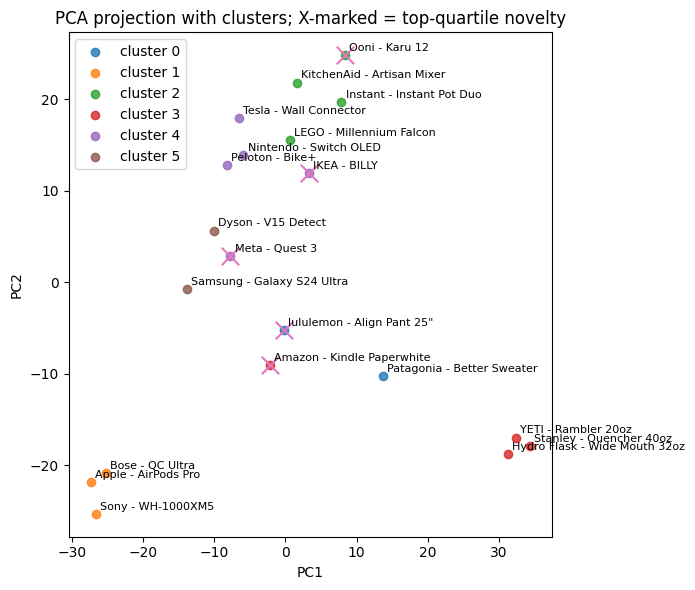

In [24]:
# --- PCA projection, clustering scatter, and labels for ALL products ---

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(X_scaled)
df_scores['pc1'] = Z[:, 0]
df_scores['pc2'] = Z[:, 1]

# Outlier threshold (top quartile of KNN novelty)
threshold = df_scores['knn_novelty'].quantile(0.75)
df_scores['is_outlier'] = df_scores['knn_novelty'] >= threshold

plt.figure(figsize=(7, 6))
for c in sorted(df_scores['cluster'].unique()):
    sub = df_scores[df_scores['cluster'] == c]
    plt.scatter(sub['pc1'], sub['pc2'], label=f'cluster {c}', alpha=0.8)

# Mark outliers with an "x"
out = df_scores[df_scores['is_outlier']]
plt.scatter(out['pc1'], out['pc2'], edgecolor='k', s=160, marker='x')

# ✅ Label ALL points with "brand - product_name"
for _, row in df_scores.iterrows():
    label = f"{row['brand']} - {row['product_name']}"
    plt.annotate(
        label, (row['pc1'], row['pc2']),
        xytext=(3, 3), textcoords='offset points',
        fontsize=8
    )

plt.legend()
plt.title('PCA projection with clusters; X-marked = top-quartile novelty')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.tight_layout()
plt.show()


## 6 · Top novel items
Sort by the two novelty scores (KNN and IsolationForest).

In [25]:
top_knn = df_scores.sort_values('knn_novelty', ascending=False)
top_iso = df_scores.sort_values('iso_novelty', ascending=False)
display(top_knn[['brand','product_name','knn_novelty','cluster']].head(10))
display(top_iso[['brand','product_name','iso_novelty','cluster']].head(10))

,brand,product_name,knn_novelty,cluster
17,IKEA,BILLY,0.744951,4
15,Meta,Quest 3,0.720907,4
13,lululemon,"Align Pant 25""",0.715206,0
18,Ooni,Karu 12,0.705907,2
5,Amazon,Kindle Paperwhite,0.704007,3
9,LEGO,Millennium Falcon,0.703185,2
16,Tesla,Wall Connector,0.699847,4
10,Patagonia,Better Sweater,0.681365,0
4,Nintendo,Switch OLED,0.678229,4
8,Instant,Instant Pot Duo,0.676537,2


,brand,product_name,iso_novelty,cluster
17,IKEA,BILLY,-0.003453,4
5,Amazon,Kindle Paperwhite,-0.007697,3
16,Tesla,Wall Connector,-0.011424,4
15,Meta,Quest 3,-0.012363,4
13,lululemon,"Align Pant 25""",-0.012737,0
8,Instant,Instant Pot Duo,-0.014090,2
18,Ooni,Karu 12,-0.014129,2
7,KitchenAid,Artisan Mixer,-0.016201,2
2,Sony,WH-1000XM5,-0.017888,1
1,Samsung,Galaxy S24 Ultra,-0.020899,5


### Extension ideas
1. **Hybrid novelty** – combine KNN distance with IsolationForest score.
2. **Category‑aware thresholds** – compute novelty within category buckets.
3. **Streaming mode** – score a new item vs. cached embedding index (FAISS).
4. **Explainability** – nearest neighbors table for each flagged outlier.
5. **Drift monitoring** – track embedding centroid shift over time.